In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import xarray as xr
import sys
import os
from re import split
import cartopy.crs as ccrs
import cartopy
import cartopy.mpl.ticker as cticker
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utils import get_pars_from_ini
location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(campaign='loc')[location]['path_data']
path_proj = get_pars_from_ini(campaign='loc')[location]['path_proj']
plt.style.use('seaborn')

In [2]:
cluster = SLURMCluster(queue="seseml",
                       memory='200GB',
                       cores=40,
                       processes=1,
                       walltime='23:40:00',
                       scheduler_options={'host': '172.22.179.3:7227', 'dashboard_address': ':7798'})

In [3]:
# cluster.scale(2)
cluster.adapt(maximum_jobs=4)
cluster

In [4]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.22.179.3:7798/status,
Dashboard: http://172.22.179.3:7798/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.22.179.3:7227,Workers: 0
Dashboard: http://172.22.179.3:7798/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
ds_xr = xr.open_zarr(f'{path_data}/zarr_rckd/KUsKAs_Wn/lores.zarr')
ds_xr = ds_xr.sel(time=~ds_xr.get_index("time").duplicated())

In [6]:
ds_xr

<xarray.Dataset>
Dimensions:            (bin_size: 1, cross_track: 25, time: 78800, range: 456, vector: 3)
Coordinates:
    alt3d              (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 1999), meta=np.ndarray>
  * cross_track        (cross_track) int64 0 1 2 3 4 5 6 ... 19 20 21 22 23 24
    lat3d              (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 1999), meta=np.ndarray>
    lon3d              (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 1999), meta=np.ndarray>
  * time               (time) datetime64[ns] 2019-08-24T22:59:26.499800 ... 2...
Dimensions without coordinates: bin_size, range, vector
Data variables: (12/58)
    DR                 (bin_size) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Xat_km             (cross_track, time) float64 dask.array<chunksize=(25, 1999), meta=np.ndarray>
    alt3D              (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 1999), meta=np.ndarray>
    alt_nav            (cross_track, time) float64 dask.array<chunksize=(25, 1999), meta=np.ndarray>
    altsurf14          (cross_track, time) float64 dask.array<chunksize=(25, 1999), meta=np.ndarray>
    altsurf35          (cross_track, time) float64 dask.array<chunksize=(25, 1999), meta=np.ndarray>
    ...                 ...
    vel95s             (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 1999), meta=np.ndarray>
    z95s               (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 1999), meta=np.ndarray>
    zhh14              (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 1999), meta=np.ndarray>
    zhh14SP            (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 1999), meta=np.ndarray>
    zhh35              (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 1999), meta=np.ndarray>
    zhh35SP            (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 1999), meta=np.ndarray>

In [7]:
alt3d = ds_xr.alt3D.sel(cross_track=12, range=0).to_dataframe()

In [8]:
ds_xr = xr.open_zarr(f'{path_data}/zarr_rckd/KUsKAsWs/lores.zarr')
ds_xr = ds_xr.sel(time=~ds_xr.get_index("time").duplicated())
ds_xr = xr.open_zarr(f'{path_data}/zarr_rckd/KUsKAs_Wn/lores.zarr')
ds_xr = ds_xr.sel(time=~ds_xr.get_index("time").duplicated())

In [9]:
alt3d_1 = ds_xr.alt3D.sel(cross_track=12, range=0).to_dataframe()

In [10]:
df_data = pd.concat([alt3d, alt3d_1])
min_lat = df_data.lat3d.min()
max_lat = df_data.lat3d.max()
min_lon = df_data.lon3d.min()
max_lon = df_data.lon3d.max()
image_extent = [int(min_lon-1), int(max_lon+1), int(min_lat-1), int(max_lat+1)]

In [11]:
df_data['day'] = pd.to_datetime(df_data.index.strftime('%Y-%m-%d'))


In [12]:
df_day = df_data.groupby(df_data.index.floor('d'))
flights = list(df_day.groups.keys())
dict_flights = {f'RF{i + 1:02d}':flights[i] for i in range(len(flights)) }
dict_fl = {flights[i]:f'RF{i + 1:02d}' for i in range(len(flights)) }

In [13]:
df_data['vuelo'] = df_data['day'].replace(dict_fl)

In [14]:
df_data

,alt3d,cross_track,lat3d,lon3d,alt3D,day,vuelo
time,,,,,,,
2019-08-24 22:59:26.499800,9309.688784,12,17.141874,118.430829,9309.688784,2019-08-24,RF01
2019-08-24 22:59:28.349800,9309.718954,12,17.144566,118.431416,9309.718954,2019-08-24,RF01
2019-08-24 22:59:30.199800,9309.661466,12,17.147238,118.431967,9309.661466,2019-08-24,RF01
2019-08-24 22:59:32.049800,9309.619589,12,17.149878,118.432559,9309.619589,2019-08-24,RF01
2019-08-24 22:59:33.899800,9309.835957,12,17.152686,118.433156,9309.835957,2019-08-24,RF01
...,...,...,...,...,...,...,...
2019-10-05 06:40:38.149800,7680.223135,12,16.221350,123.954414,7680.223135,2019-10-05,RF26
2019-10-05 06:40:39.999800,7680.200020,12,16.219875,123.952402,7680.200020,2019-10-05,RF26
2019-10-05 06:40:41.849800,7680.217945,12,16.218466,123.950316,7680.217945,2019-10-05,RF26


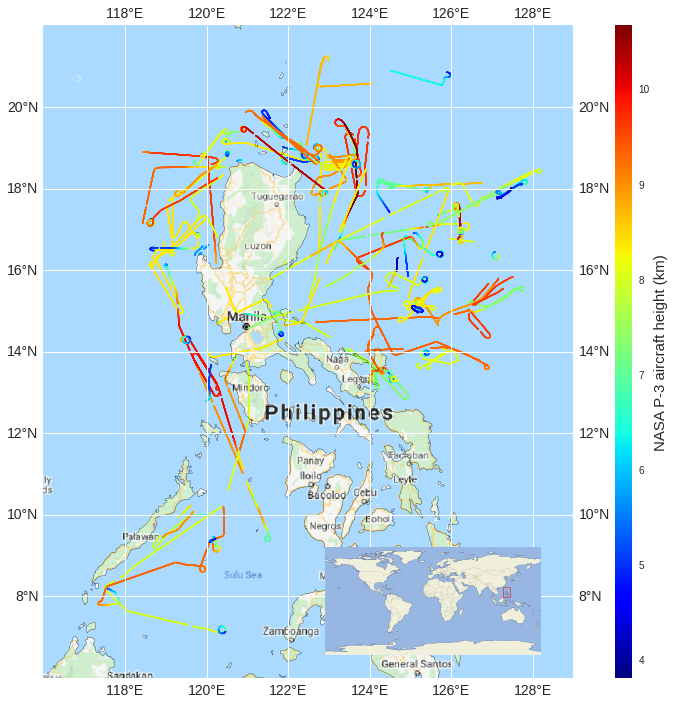

In [15]:
plt.rcParams.update({'font.size': 14})
axis_font = {'size':'15'}

fig = plt.figure(figsize=(15,12))
request = cimgt.GoogleTiles()
# request = cimgt.GoogleWTS()
# request = cimgt.OSM()
projection = ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(image_extent)
ax.coastlines()
ax.add_image(request, 6)
ax.gridlines(draw_labels=True, rasterized=True)
bmap = ax.scatter(df_data.lon3d, df_data.lat3d, c=df_data.alt3D/1000, transform=ccrs.PlateCarree(), cmap='jet', s=1)
clb = plt.colorbar(bmap, aspect=40)
clb.set_label('NASA P-3 aircraft height (km)', **axis_font)


posn = ax.get_position()

# Map window
mp_left, mp_bottom, mp_width, mp_height = posn.x1 - 0.23, posn.y1 * 0.13, 0.2, 0.2
rect_mp = [mp_left, mp_bottom, mp_width, mp_height]
ax1 = fig.add_axes(rect_mp, projection=projection, zorder=0)
ax1.set_extent((-180, 180, -90, 90))
ax1.coastlines(linewidth=0.1)
ax1.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5, linewidth=0.1)
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
lon0, lon1, lat0, lat1 = image_extent
box_x = [lon0, lon1, lon1, lon0, lon0]
box_y = [lat0, lat0, lat1, lat1, lat0]
ax1.plot(box_x, box_y, color='red', transform=ccrs.Geodetic(), linewidth=0.5)
fig.savefig('../results/df_filtered/map.jpg', bbox_inches="tight", dpi=300)

In [7]:
df = pd.read_csv('../results/all_filtered_202111111947.csv')
df.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
df['time'] = pd.to_datetime(df.time)
df.index = df.time
df.drop(columns='time', inplace=True)

In [9]:
times = list(df.index)

In [24]:
ds_vel_pos = ds_xr.vel14.sel(time=times).where(ds_xr.vel14 > 0)
ds_vel_neg = ds_xr.vel14.sel(time=times).where(ds_xr.vel14 <= 0)

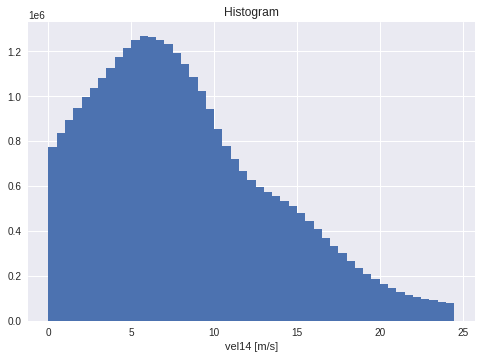

In [26]:
hist_14 = xr.plot.hist(ds_vel_pos,bins=np.arange(0, 25, .5))

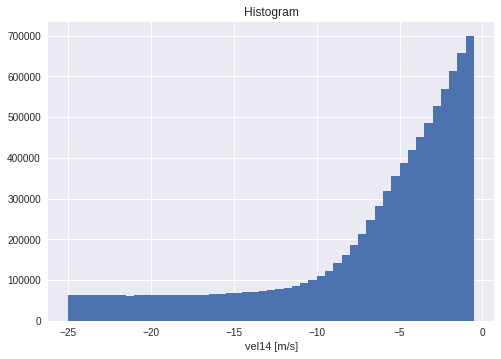

In [28]:
hist_14_neg = xr.plot.hist(ds_vel_neg,bins=np.arange(-25, 0, .5))

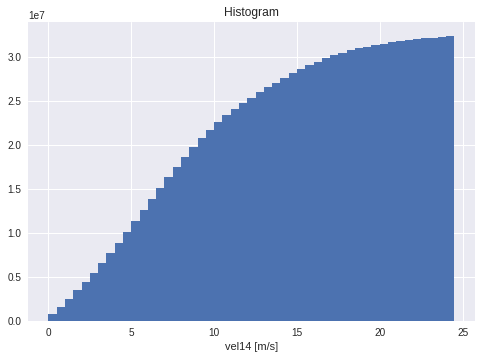

In [29]:
cum_14 = xr.plot.hist(ds_vel_pos,bins=np.arange(0, 25, .5), cumulative=True)